# Customer RFM Segmentation
Customer segmentation used to target shipping cost voucher receiver candidate. As stated on my analysis before, the use of voucher doesn't seem to have any effect on user's satisfaction. However, this strategy may be able to increase user retention. Since the majority of users only order at most 2 times in the span of 2 years this is a severe problem for the ecommerce. Therefore a strategy needed to be laid out to increase user transaction frequency and monetary value.

## Free Shipping Voucher Strategy
Shipping cost voucher will be awarded to customer which has lower transaction frequency but relatively higher monetary value. Not only that, but customer will be able to use the voucher only after it fulfill some conditions such as minimum transaction value, applied only to Official Store, or on certain occassion or date.

## Library Import and Configuration

In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# import postgres connection factory utility
from util.dbconn import DbConn

In [85]:
WAREHOUSE_CONN = {
    'user': 'postgres',
    'password': 'qshOke46RvOg0',
    'host': 'localhost',
    'port': '8084',
    'dbname': 'warehouse'
}

In [86]:
postgres_conn = DbConn(WAREHOUSE_CONN).get_conn()

## Data Overview

In [87]:
customer_rfm_query = """WITH all_user AS (
SELECT
	DISTINCT od.user_name,
	ud.user_sk,
	ud.customer_state_id AS state_id,
	ud.customer_city AS city
FROM
	order_dim od
LEFT JOIN user_dim ud ON
	od.user_name = ud.user_name
WHERE
	od.order_status NOT IN ('canceled', 'unavailable')),
distinct_fc_monev AS (
SELECT
	*
FROM
	fact_customer_monetary_value fcmv2
WHERE
	user_sk IS NOT NULL
	AND order_date IS NULL)
SELECT
	u.user_name,
	fcmv.avg_spending,
	EXTRACT(epoch FROM mcof.avg_time_between_order/86400)::int8 AS avg_day_between_order,
	mcof.order_count,
	EXTRACT(epoch FROM mcr.last_order_interval/86400)::int8 AS last_order_days
FROM
	all_user u
LEFT JOIN distinct_fc_monev fcmv ON
	u.user_sk = fcmv.user_sk
LEFT JOIN mart_customer_order_frequency mcof ON
	u.user_name = mcof.user_name
LEFT JOIN mart_customer_recency mcr ON
	u.user_name = mcr.user_name;"""
customer_rfm = pd.read_sql(customer_rfm_query, con=postgres_conn)
display(customer_rfm.info())
display(customer_rfm.head(5))
display(customer_rfm.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94990 entries, 0 to 94989
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_name              94990 non-null  object 
 1   avg_spending           94983 non-null  float64
 2   avg_day_between_order  94986 non-null  float64
 3   order_count            94986 non-null  float64
 4   last_order_days        94986 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.6+ MB


None

,user_name,avg_spending,avg_day_between_order,order_count,last_order_days
0,00053a61a98854899e70ed204dd4bafe,419180.0,0.0,1.0,232.0
1,000d460961d6dbfa3ec6c9f5805769e1,36680.0,0.0,1.0,284.0
2,000ed48ceeb6f4bf8ad021a10a3c7b43,20750.0,0.0,1.0,151.0
3,0010fb34b966d44409382af9e8fd5b77,61800.0,0.0,1.0,227.0
4,0012929d977a8d7280bb277c1e5f589d,155650.0,0.0,1.0,366.0


,avg_spending,avg_day_between_order,order_count,last_order_days
count,9.498300e+04,94986.000000,94986.000000,94986.000000
mean,1.607270e+05,2.447171,1.033858,288.394627
std,2.198878e+05,23.371340,0.210807,153.005601
min,9.590000e+03,0.000000,1.000000,45.000000
25%,6.241000e+04,0.000000,1.000000,164.000000
50%,1.057400e+05,0.000000,1.000000,269.000000
75%,1.769650e+05,0.000000,1.000000,397.000000
max,1.366408e+07,609.000000,16.000000,774.000000


### Check for Null Value

In [88]:
customer_rfm.isnull().sum()

user_name                0
avg_spending             7
avg_day_between_order    4
order_count              4
last_order_days          4
dtype: int64

## Exploratory Data Analysis

### Order Frequency

,order_count,user_name
0,1.0,92099
1,2.0,2651
2,3.0,188
3,4.0,29
4,5.0,9
5,6.0,5
6,7.0,3
7,9.0,1
8,16.0,1


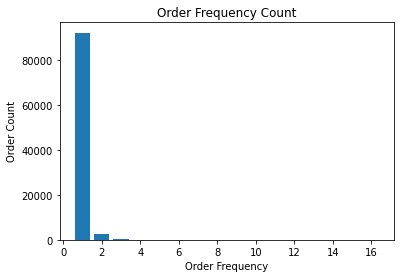

In [89]:
fig, ax = plt.subplots()
t1 = customer_rfm.loc[:, ['user_name', 'order_count']] \
        .groupby('order_count', as_index=False).count()
ax.bar(t1['order_count'], t1['user_name'])
ax.set_title('Order Frequency Count')
ax.set_xlabel('Order Frequency')
ax.set_ylabel('Order Count')

display(t1)
plt.show()

### Order Recency

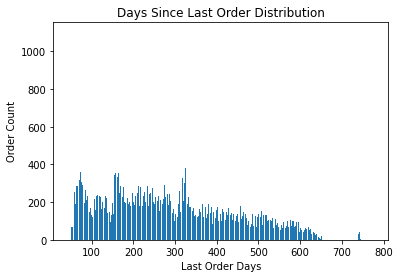

,days_since_last_order,order_count
0,45.0,1
1,50.0,11
2,51.0,38
3,52.0,66
4,53.0,71
5,54.0,68
6,55.0,93
7,56.0,139
8,57.0,181
9,58.0,243


In [90]:
fig, ax = plt.subplots()
t1 = customer_rfm.loc[:, ['user_name', 'last_order_days']] \
        .groupby('last_order_days', as_index=False).count()
ax.bar(t1['last_order_days'], t1['user_name'])
ax.set_title('Days Since Last Order Distribution')
ax.set_xlabel('Last Order Days')
ax.set_ylabel('Order Count')

plt.show()
t1.columns = ['days_since_last_order', 'order_count']
display(t1.head(15))

### Delay Between Order

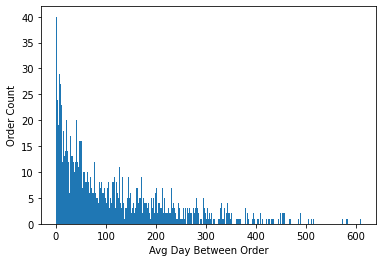

,avg_day_between_order,user_name
0,1.0,40
1,2.0,37
2,3.0,24
3,4.0,25
4,5.0,19


,avg_day_between_order,user_name
394,524.0,2
395,573.0,1
396,581.0,1
397,583.0,1
398,609.0,1


In [91]:
fig, ax = plt.subplots()
t0 = customer_rfm[customer_rfm['order_count'] != 1]
t0 = t0[t0['avg_day_between_order'] != 0]
t1 = t0.loc[:, ['user_name', 'avg_day_between_order']] \
        .groupby('avg_day_between_order', as_index=False).count()
ax.bar(t1['avg_day_between_order'], t1['user_name'])
# ax.set_title('Last Order Days Distribution')
ax.set_xlabel('Avg Day Between Order')
ax.set_ylabel('Order Count')

plt.show()
display(t1.head(5))
display(t1.tail(5))

### Monetary Value

liat data mentahnya dulu <br>
pake bar chart 

,monetary_value,user_name
0,0,94459
1,1,462
2,2,49
3,3,7
4,4,2
5,5,3
6,6,0
7,7,0
8,8,0
9,9,1


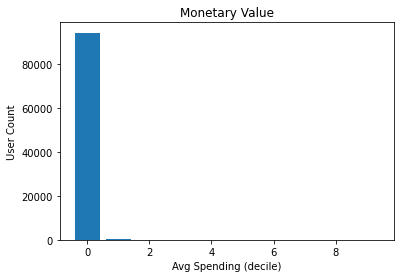

In [92]:
fig, ax = plt.subplots()

t0 = customer_rfm.copy()

t0['monetary_value'] = pd.cut(customer_rfm['avg_spending'], bins=10, labels=range(0, 10))
t1 = t0.loc[:, ['user_name', 'monetary_value']] \
        .groupby('monetary_value', as_index=False).count()
ax.bar(t1['monetary_value'], t1['user_name'])
ax.set_title('Monetary Value')
ax.set_xlabel('Avg Spending (decile)')
ax.set_ylabel('User Count')

display(t1)
plt.show()

## Baseline Model
Manually assigned RFM score based on percentile.
<table>
    <tr>
        <th>Recency</th>
        <th>Frequency</th>
        <th>Monetary</th>
    </tr>
    <tr>
        <td>R-Tier-1 (most recent)</td>
        <td>F-Tier-1 (most frequent)</td>
        <td>M-Tier-1 (highest spend)</td>
    </tr>
    <tr>
        <td>R-Tier-2</td>
        <td>F-Tier-2</td>
        <td>M-Tier-2</td>
    </tr>
    <tr>
        <td>R-Tier-3</td>
        <td>F-Tier-3</td>
        <td>M-Tier-3</td>
    </tr>
    <tr>
        <td>R-Tier-4 (least recent)</td>
        <td>F-Tier-4 (least frequent)</td>
        <td>M-Tier-4 (lowest spend)</td>
    </tr>
</table>
Reiterating the goals again, the strategy prefer customer which has lower frequency but relatively higher monetary value. Below are the segment name assignment based on customer RFM score:<br>
<ul>
    <li>High-spending Active Loyal Customer (1-1-1, 1-1-2)</li>
    <li>Churned High-spending Customer* (4-4-1, 4-4-2, 4-3-1, 4-3-2)</li>
    <li>High-spending New Customer* (1-4-1, 1-4-2)</li>
    <li>Worst Customer (4-4-4, 4-3-4, 3-4-4)</li>
</ul>
<b>Note:</b>
* The best candidate to receive free shipping voucher is marked with asterisk

1 2 x
2 x x
3 x x boleh dikasih voucher belanja juga krn sudah lama nggk beli
semua customer harus punya cluster

In [93]:
rfm = customer_rfm.copy()
rfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94990 entries, 0 to 94989
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_name              94990 non-null  object 
 1   avg_spending           94983 non-null  float64
 2   avg_day_between_order  94986 non-null  float64
 3   order_count            94986 non-null  float64
 4   last_order_days        94986 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.6+ MB


### Recency Tier

,recency_tier,user_name
0,1,38077
1,2,34877
2,3,19017
3,4,3015


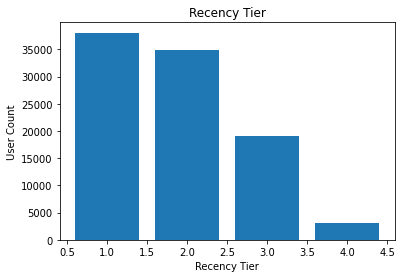

In [94]:
# Tier is reversed since the lowest bin is the least recent
# this rule applies to frequency and monetary as well
recency_labels = [
    1,
    2,
    3,
    4
]
rfm['recency_tier'] = pd.cut(customer_rfm['last_order_days'], bins=4, labels=recency_labels)

fig, ax = plt.subplots()

t1 = rfm.loc[:, ['user_name', 'recency_tier']] \
        .groupby('recency_tier', as_index=False).count()
ax.bar(t1['recency_tier'], t1['user_name'])
ax.set_title('Recency Tier')
ax.set_xlabel('Recency Tier')
ax.set_ylabel('User Count')

display(t1)
plt.show()

### Frequency Tier

,frequency_tier,user_name
0,4,94967
1,3,17
2,2,1
3,1,1


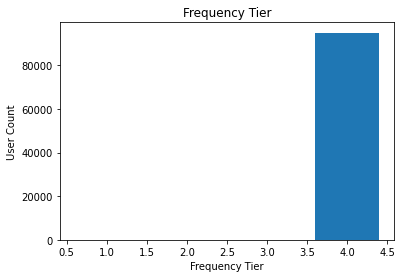

In [95]:
frequency_labels = [
    4,
    3,
    2,
    1
]
rfm['frequency_tier'] = pd.cut(customer_rfm['order_count'], bins=4, labels=frequency_labels)

fig, ax = plt.subplots()

t1 = rfm.loc[:, ['user_name', 'frequency_tier']] \
        .groupby('frequency_tier', as_index=False).count()
ax.bar(t1['frequency_tier'], t1['user_name'])
ax.set_title('Frequency Tier')
ax.set_xlabel('Frequency Tier')
ax.set_ylabel('User Count')

display(t1)
plt.show()

#### Remove Outlier

,frequency_tier,user_name
0,4,94938
1,3,38
2,2,8
3,1,1


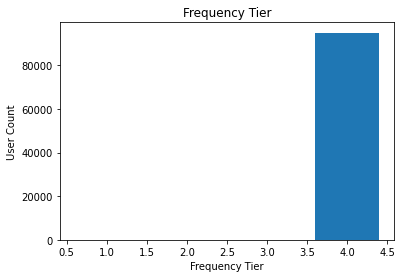

In [96]:
t0 = rfm.copy()

t0 = t0[t0['order_count'] != 16]
t0['frequency_tier'] = pd.cut(t0['order_count'], bins=4, labels=frequency_labels)

fig, ax = plt.subplots()

t1 = t0.loc[:, ['user_name', 'frequency_tier']] \
        .groupby('frequency_tier', as_index=False).count()
ax.bar(t1['frequency_tier'], t1['user_name'])
ax.set_title('Frequency Tier')
ax.set_xlabel('Frequency Tier')
ax.set_ylabel('User Count')

display(t1)
plt.show()

#### Remove User with Order Count of 1

,frequency_tier,user_name
0,4,2877
1,3,9
2,2,0
3,1,1


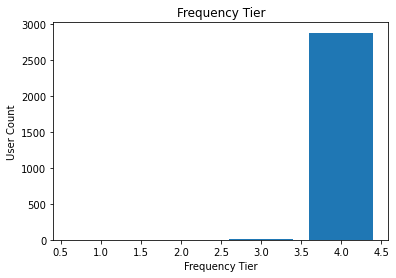

In [97]:
t0 = rfm.copy()

t0 = t0[t0['order_count'] > 1]
t0['frequency_tier'] = pd.cut(t0['order_count'], bins=4, labels=frequency_labels)

fig, ax = plt.subplots()

t1 = t0.loc[:, ['user_name', 'frequency_tier']] \
        .groupby('frequency_tier', as_index=False).count()
ax.bar(t1['frequency_tier'], t1['user_name'])
ax.set_title('Frequency Tier')
ax.set_xlabel('Frequency Tier')
ax.set_ylabel('User Count')

display(t1)
plt.show()

#### Remove Outlier and Frequency of 1

,frequency_tier,user_name
0,4,2839
1,3,29
2,2,9
3,1,8


,order_count,user_name
0,2.0,2651
1,3.0,188
2,4.0,29
3,5.0,9
4,6.0,5
5,7.0,3


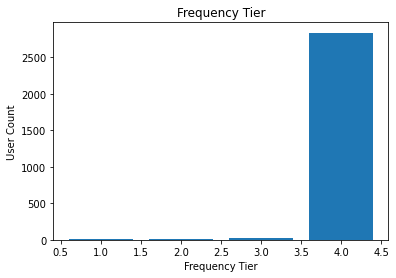

In [98]:
t0 = rfm.copy()

t0 = t0[(t0['order_count'] > 1) & (t0['order_count'] != 16) & (t0['order_count'] != 9)]
t0['frequency_tier'] = pd.cut(t0['order_count'], bins=4, labels=frequency_labels)

fig, ax = plt.subplots()

t1 = t0.loc[:, ['user_name', 'frequency_tier']] \
        .groupby('frequency_tier', as_index=False).count()
t2 = t0.loc[:, ['user_name', 'order_count']] \
        .groupby('order_count', as_index=False).count()
ax.bar(t1['frequency_tier'], t1['user_name'])
ax.set_title('Frequency Tier')
ax.set_xlabel('Frequency Tier')
ax.set_ylabel('User Count')

display(t1)
display(t2)
plt.show()

### Monetary Tier

In [121]:
customer_rfm['avg_spending'].describe()

count    9.498300e+04
mean     1.607270e+05
std      2.198878e+05
min      9.590000e+03
25%      6.241000e+04
50%      1.057400e+05
75%      1.769650e+05
max      1.366408e+07
Name: avg_spending, dtype: float64

,monetary_tier,user_name
0,4,94959
1,3,20
2,2,3
3,1,1


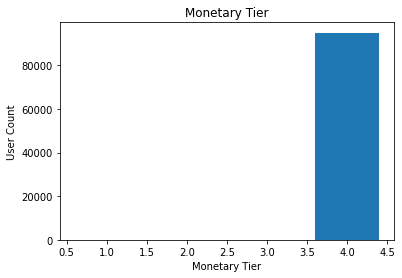

In [99]:
monetary_labels = [
    4,
    3,
    2,
    1
]
# cek pake selain pd.cut
rfm['monetary_tier'] = pd.cut(customer_rfm['avg_spending'], bins=4, labels=monetary_labels)

fig, ax = plt.subplots()

t1 = rfm.loc[:, ['user_name', 'monetary_tier']] \
        .groupby('monetary_tier', as_index=False).count()
ax.bar(t1['monetary_tier'], t1['user_name'])
ax.set_title('Monetary Tier')
ax.set_xlabel('Monetary Tier')
ax.set_ylabel('User Count')

display(t1)
plt.show()

In [100]:
rfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94990 entries, 0 to 94989
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   user_name              94990 non-null  object  
 1   avg_spending           94983 non-null  float64 
 2   avg_day_between_order  94986 non-null  float64 
 3   order_count            94986 non-null  float64 
 4   last_order_days        94986 non-null  float64 
 5   recency_tier           94986 non-null  category
 6   frequency_tier         94986 non-null  category
 7   monetary_tier          94983 non-null  category
dtypes: category(3), float64(4), object(1)
memory usage: 3.9+ MB


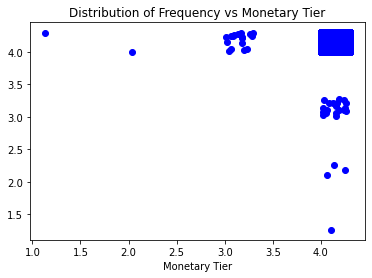

In [101]:
# Adding randomness to the scatter plot (for visualization only)
t1 = rfm.copy()
t1['frequency_tier'] = t1.apply(lambda row: row['frequency_tier']+(np.random.rand()*0.3), axis=1)
t1['monetary_tier'] = t1.apply(lambda row: row['monetary_tier']+(np.random.rand()*0.3), axis=1)

fig, ax = plt.subplots()
ax.scatter(t1['frequency_tier'], t1['monetary_tier'], color='b')
ax.set_title('Distribution of Frequency vs Monetary Tier')
ax.set_xlabel('Frequency Tier')
ax.set_xlabel('Monetary Tier')

plt.show()

### High Spending Active Loyal Customer

In [102]:
high_spending_active_loyal_cust_cond = \
    (rfm['recency_tier'] == 1) \
    & (rfm['frequency_tier'] == 1) \
    & (rfm['monetary_tier'] >= 2)

high_spending_active_loyal_cust = rfm[high_spending_active_loyal_cust_cond]
display(high_spending_active_loyal_cust.head(10))
display(high_spending_active_loyal_cust.shape)

,user_name,avg_spending,avg_day_between_order,order_count,last_order_days,recency_tier,frequency_tier,monetary_tier


(0, 8)

### Churned High Spending Customer

In [103]:
churned_high_spending_cust_cond = \
    (rfm['recency_tier'] >= 3) \
    & (rfm['frequency_tier'] <= 3) \
    & (rfm['monetary_tier'] >= 3)

churned_high_spending_cust = rfm[churned_high_spending_cust_cond]
display(churned_high_spending_cust.head(10))
display(churned_high_spending_cust.shape)

,user_name,avg_spending,avg_day_between_order,order_count,last_order_days,recency_tier,frequency_tier,monetary_tier
4361,5e713be0853d8986528d7869a0811d2b,4042740.0,0.0,1.0,621.0,4,4,3
23780,011875f0176909c5cf0b14a9138bb691,4016910.0,0.0,1.0,579.0,3,4,3
27981,5d09b0d82126457e2a8ebfb9c9a1ffc4,3736220.0,0.0,1.0,615.0,4,4,3
59530,03796b63235e0e0a299084988c662c7e,3602470.0,0.0,1.0,604.0,4,4,3
69483,da122df9eeddfedc1dc1f5349a1a690c,3785815.0,0.0,2.0,565.0,3,4,3
69598,dc4802a71eae9be1dd28f5d788ceb526,6929310.0,0.0,1.0,613.0,4,4,2
70420,edf81e1f3070b9dac83ec83dacdbb9bc,4194760.0,0.0,1.0,548.0,3,4,3
78065,931eabdf0636b8fd60369a8d759917d6,3666420.0,0.0,1.0,526.0,3,4,3
94233,eebb5dda148d3893cdaf5b5ca3040ccb,4764340.0,0.0,1.0,548.0,3,4,3
94948,ff4159b92c40ebe40454e3e6a7c35ed6,6726660.0,0.0,1.0,512.0,3,4,3


(10, 8)

### High Spending New Customer

In [104]:
high_spending_new_cust_cond = \
    (rfm['recency_tier'] <= 2) \
    & (rfm['frequency_tier'] <= 3) \
    & (rfm['monetary_tier'] >= 3)

high_spending_new_cust = rfm[high_spending_new_cust_cond]
display(high_spending_new_cust.head(10))
display(high_spending_new_cust.shape)

,user_name,avg_spending,avg_day_between_order,order_count,last_order_days,recency_tier,frequency_tier,monetary_tier
27107,48e1ac109decbb87765a3eade6854098,4681780.0,0.0,1.0,118.0,1,4,3
37635,2c3b08cf3584d8c0a81d9618a73aa219,3526460.0,0.0,1.0,192.0,1,4,3
38572,4007669dec559734d6f53e029e360987,6081540.0,0.0,1.0,328.0,2,4,3
39685,58483a1c055dfb600f57c5b867174542,4034440.0,0.0,1.0,135.0,1,4,3
46620,edde2314c6c30e864a128ac95d6b2112,4513320.0,0.0,1.0,76.0,1,4,3
46735,f0767ae738c3d90e7b737d7b8b8bb4d1,3979550.0,0.0,1.0,157.0,1,4,3
47868,0a0a92112bd4c708ca5fde585afaa872,13664080.0,0.0,1.0,384.0,2,4,1
54920,a229eba70ec1c2abef51f04987deb7a5,4445500.0,0.0,1.0,140.0,1,4,3
56138,bc5e25094a7d51b6aee35236572e64f4,3826800.0,0.0,1.0,265.0,2,4,3
74209,3fec1a05177762f279472253113d568a,3792590.0,0.0,1.0,211.0,1,4,3


(14, 8)

### Worst Customer

In [105]:
worst_cust_cond = \
    (rfm['recency_tier'] >= 3) \
    & (rfm['frequency_tier'] <= 3) \
    & (rfm['monetary_tier'] <= 3)

worst_cust = rfm[worst_cust_cond]
display(worst_cust.head(10))
display(worst_cust.shape)

,user_name,avg_spending,avg_day_between_order,order_count,last_order_days,recency_tier,frequency_tier,monetary_tier
5,001926cef41060fae572e2e7b30bd2a4,91210.0,0.0,1.0,427.0,3,4,4
8,001f3c4211216384d5fe59b041ce1461,35840.0,0.0,1.0,578.0,3,4,4
13,0036b4a3d09ad551a5188c2e374da402,162770.0,0.0,1.0,435.0,3,4,4
17,0046311f458d8041b00063cb99482903,112330.0,0.0,1.0,443.0,3,4,4
21,005e32bc930906dc6b65fb9d11cce3e2,49600.0,0.0,1.0,410.0,3,4,4
28,008fb2ecc75561d202dd4db2e0ceec25,40770.0,0.0,1.0,505.0,3,4,4
36,00ba737b18a7996f68cb8a99556bedd4,141140.0,0.0,1.0,464.0,3,4,4
38,00cc7c54469f4177319d6bb12e883652,187940.0,0.0,1.0,548.0,3,4,4
44,00ecc71175078e2cac5547a5656e9622,235130.0,0.0,1.0,495.0,3,4,4
56,0158b70c1d28da409abddfcaa5f0801a,77060.0,0.0,1.0,540.0,3,4,4


(22028, 8)

### Base Model Cluster Result

In [106]:
hsalc = high_spending_active_loyal_cust.copy()
chsc = churned_high_spending_cust.copy()
hsnc = high_spending_new_cust.copy()
wc = worst_cust.copy()

chsc = chsc.loc[:, ['recency_tier', 'frequency_tier', 'monetary_tier']]
hsnc = hsnc.loc[:, ['recency_tier', 'frequency_tier', 'monetary_tier']]
wc = wc.loc[:, ['recency_tier', 'frequency_tier', 'monetary_tier']]

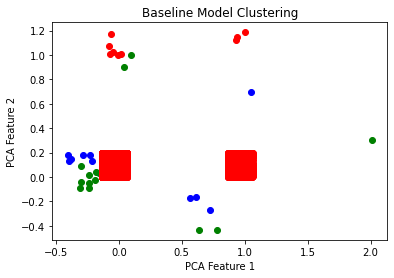

In [107]:
def add_random_noise(arr, noise_strength):
    for i, v in enumerate(arr):
        arr[i] = v + (np.random.rand() * noise_strength)
    
    return arr

chsc_pca = PCA(n_components=2)
chsc = chsc_pca.fit_transform(chsc)
chsc[:, 0] = add_random_noise(chsc[:, 0], 0.2)
chsc[:, 1] = add_random_noise(chsc[:, 1], 0.2)

hsnc_pca = PCA(n_components=2)
hsnc = hsnc_pca.fit_transform(hsnc)
hsnc[:, 0] = add_random_noise(hsnc[:, 0], 0.2)
hsnc[:, 1] = add_random_noise(hsnc[:, 1], 0.2)

wc_pca = PCA(n_components=2)
wc = wc_pca.fit_transform(wc)
wc[:, 0] = add_random_noise(wc[:, 0], 0.2)
wc[:, 1] = add_random_noise(wc[:, 1], 0.2)

fig, ax = plt.subplots()

ax.scatter(chsc[:, 0], chsc[:, 1], color='b')
ax.scatter(hsnc[:, 0], hsnc[:, 1], color='g')
ax.scatter(wc[:, 0], wc[:, 1], color='r')
ax.set_xlabel('PCA Feature 1')
ax.set_ylabel('PCA Feature 2')
ax.set_title('Baseline Model Clustering')

plt.show()

### Baseline Model Evaluation

In [108]:
from sklearn.metrics import silhouette_score

chsc = pd.DataFrame(chsc)
hsnc = pd.DataFrame(hsnc)
wc = pd.DataFrame(wc)

chsc['cluster'] = [0] * len(chsc)
hsnc['cluster'] = [1] * len(hsnc)
wc['cluster'] = [2] * len(wc)

merged = pd.concat([chsc, hsnc, wc])

# silhouette_score(merged.iloc[:, [0,1,2]], merged['cluster'])

## Data Preprocessing

In [109]:
from sklearn.preprocessing import MinMaxScaler

In [110]:
df = customer_rfm.copy()
df = df.loc[:, ['last_order_days', 'order_count', 'avg_spending']]

In [111]:
df = df.dropna()

In [112]:
# TODO: more preprocessing proper scaling

In [113]:
mmscaler = MinMaxScaler()
df = pd.DataFrame(mmscaler.fit_transform(df))
df.columns = ['last_order_days', 'order_count', 'avg_spending']

In [114]:
display(df.head(10))

,last_order_days,order_count,avg_spending
0,0.256516,0.0,0.029997
1,0.327846,0.0,0.001984
2,0.145405,0.0,0.000817
3,0.249657,0.0,0.003824
4,0.440329,0.0,0.010697
5,0.524005,0.0,0.005978
6,0.050754,0.0,0.002050
7,0.100137,0.0,0.003936
8,0.731139,0.0,0.001922
9,0.035665,0.0,0.006049


## Model Selection

In [115]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

### Using Silhouette Score to get optimal cluster

In [116]:
# df1 = df.copy()

# n_cluster = []
# silhouette_scores = []

# for i in range(2,15):
#     print('Training model ...')
#     kmeans = KMeans(n_clusters=i, random_state=111)
#     y = kmeans.fit_predict(df1)
#     print('Calculating silhouette score ...')
#     sc = silhouette_score(df1.head(2000), y[:2000])
#     n_cluster.append(i)
#     silhouette_scores.append(sc)
#     print('For n_cluster = {n} The avg of silhouette score is {score}'.format(n=i, score=sc))

# fig, ax = plt.subplots()

# ax.plot(n_cluster, silhouette_scores)
# ax.set_xlabel('n Cluster')
# ax.set_ylabel('Silhouette score')

# plt.show()

Training model ...
Calculating silhouette score ...
For n_cluster = 2 The avg of silhouette score is 0.5890987826093647
Training model ...
Calculating silhouette score ...
For n_cluster = 3 The avg of silhouette score is 0.5704102543044142
Training model ...
Calculating silhouette score ...
For n_cluster = 4 The avg of silhouette score is 0.5357556053904186
Training model ...
Calculating silhouette score ...
For n_cluster = 5 The avg of silhouette score is 0.5218454520234295
Training model ...
Calculating silhouette score ...
For n_cluster = 6 The avg of silhouette score is 0.5307521157286188
Training model ...
Calculating silhouette score ...
For n_cluster = 7 The avg of silhouette score is 0.5238479638803812
Training model ...
Calculating silhouette score ...
For n_cluster = 8 The avg of silhouette score is 0.5018780262321111
Training model ...
Calculating silhouette score ...
For n_cluster = 9 The avg of silhouette score is 0.5027088406048894
Training model ...
Calculating silhouett

KeyboardInterrupt: 

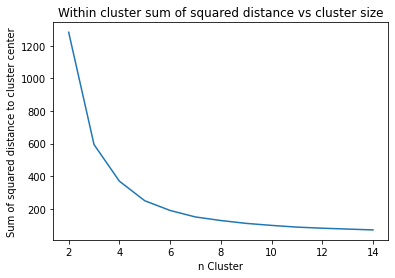

In [120]:
df1 = df.copy()

n_cluster = []
inertia_values = []

for i in range(2,15):
    kmeans = KMeans(n_clusters=i, random_state=111)
    y = kmeans.fit_predict(df1)
    n_cluster.append(i)
    inertia_values.append(kmeans.inertia_)

fig, ax = plt.subplots()

ax.plot(n_cluster, inertia_values)
ax.set_title('Within cluster sum of squared distance vs cluster size')
ax.set_xlabel('n Cluster')
ax.set_ylabel('Sum of squared distance to cluster center')

plt.show()

## K-Means

In [122]:
kmeans = KMeans(n_clusters=3, random_state=222)
y = kmeans.fit_predict(df1)

### K-Means Evaluation

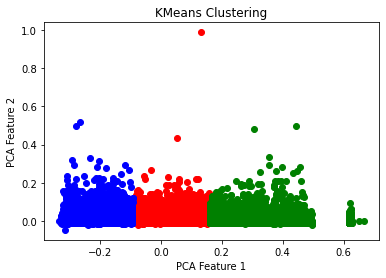

In [124]:
# sc = silhouette_score(df1, y)
# display("Silhouette score:", sc)

kmeans_pca = PCA(n_components=2)
kmeans_df = df.copy()
kmeans_df = kmeans_pca.fit_transform(kmeans_df)

kmeans_df = pd.DataFrame(kmeans_df)
kmeans_df['label'] = y

cluster_1 = kmeans_df[kmeans_df['label'] == 0]
cluster_2 = kmeans_df[kmeans_df['label'] == 1]
cluster_3 = kmeans_df[kmeans_df['label'] == 2]

fig, ax = plt.subplots()

ax.scatter(cluster_1.iloc[:, 0], cluster_1.iloc[:, 1], color='r')
ax.scatter(cluster_2.iloc[:, 0], cluster_2.iloc[:, 1], color='b')
ax.scatter(cluster_3.iloc[:, 0], cluster_3.iloc[:, 1], color='g')
ax.set_xlabel('PCA Feature 1')
ax.set_ylabel('PCA Feature 2')
ax.set_title('KMeans Clustering')

plt.show()

## Hierarchical Agglomerative

In [33]:
from sklearn.cluster import AgglomerativeClustering

In [34]:
df1 = df.copy()
df1 = df1.head(5000)

agglomerative_clustering = AgglomerativeClustering(
                                n_clusters=2,
                                affinity='euclidean',
                                linkage='ward')
y = agglomerative_clustering.fit_predict(df1)
sc = silhouette_score(df1, y)
print('The average silhouette score is {score}'.format(score=sc))

The average silhouette score is 0.5839334327316632


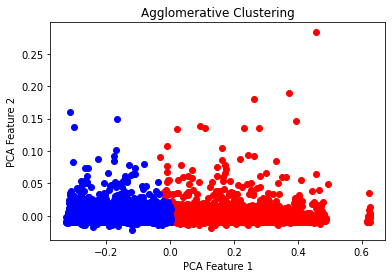

In [35]:
ac_pca = PCA(n_components=2)
ac_df = df1.copy()
ac_df = ac_pca.fit_transform(ac_df)

ac_df = pd.DataFrame(ac_df)
ac_df['label'] = y

cluster_1 = ac_df[ac_df['label'] == 0]
cluster_2 = ac_df[ac_df['label'] == 1]

fig, ax = plt.subplots()

ax.scatter(cluster_1.iloc[:, 0], cluster_1.iloc[:, 1], color='r')
ax.scatter(cluster_2.iloc[:, 0], cluster_2.iloc[:, 1], color='b')
ax.set_xlabel('PCA Feature 1')
ax.set_ylabel('PCA Feature 2')
ax.set_title('Agglomerative Clustering')

plt.show()

**visualisasi per 2 fitur utk tampilin semuanya

## DBSCAN

In [36]:
from sklearn.cluster import DBSCAN

In [37]:
df1 = df.copy()

dbscan = DBSCAN(eps=0.5, metric='euclidean')
y = dbscan.fit_predict(df1)
#sc = silhouette_score(df1, y)
#print("The average silhouette score is {score}".format(score=sc))